In [1]:
import pickle
import numpy as np
import scipy
from data import get_settings
import matplotlib.pyplot as plt

In [2]:
settings = ["simu1", "simu2", "simu3"]

alpha = 0.1
z_alpha = scipy.stats.norm.ppf(1 - alpha, loc=0, scale=1)
z_half_alpha =  scipy.stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)


In [3]:
# compute true ECE using numerical intergration for setting 1 and setting 2

settings1_ece_list = []
settings2_ece_list = []

gap = 0.0000001
p = np.arange(gap, 1 - 0.0000001, gap)
beta1_list = np.arange(0, 1.01, 0.05)


beta_pdf = scipy.stats.beta.pdf(p, a = 5, b = 0.5)
reversed_index = np.arange(len(p) - 1, -1, -1)

for beta1 in beta1_list:
    beta0 = 0
    exponent = beta0 + beta1 * np.log(p / (1-p))
    q = np.exp(exponent) / (1 + np.exp(exponent))
    bin_gap = 0.02
    estimator_mean = 0
    ece_value = np.sqrt((np.power((p - q)[p > 0.5], 2) * gap).sum() * 2)
    # print(ece_value)
    settings1_ece_list.append(ece_value)
    ece_value = np.sqrt((np.power((p - q)[p > 0.5], 2) * (beta_pdf[p > 0.5] +  beta_pdf[reversed_index][p > 0.5]) * gap).sum())
    # print(ece_value)
    settings2_ece_list.append(ece_value)

epsilon_perturbation_list = np.arange(0, 0.1, 0.005)
settings3_ece_list = np.sqrt(2 * epsilon_perturbation_list * epsilon_perturbation_list)

ece_settings = {
    "simu1": np.array(settings1_ece_list),
    "simu2": np.array(settings2_ece_list),
    "simu3": np.array(settings3_ece_list),
}

In [4]:

def f_z(x):
    return 2.0 / 3 * np.power(x, 3) - np.power(x, 4) + 0.4 * np.power(x, 5)

temp_sum = 0
topk = 2
num_class = 10
gap = 0.001
for z1 in np.arange(0, 1, gap):
    if z1 < topk / num_class:
        z2_lower = topk / num_class - z1
    else:
        z2_lower = 0
    z2_upper = 1 - z1
    for z2 in np.arange(z2_lower, z2_upper, gap):
        cell_sum = (np.power(z1, 2) + np.power(z2, 2)) - 2 * (np.power(z1, 3) + np.power(z2, 3)) + (np.power(z1 * z1 + z2 * z2 , 2) )
        temp_sum += cell_sum * gap * gap
sigma0_threshold = temp_sum       

sigma_0_settings = {
    "simu1": f_z(1) - f_z(0.5),
    "simu2": f_z(1) - f_z(0.5),
    "simu3": sigma0_threshold,
}

In [5]:
bootstrap_coverage_dict = {}
bootstrap_type2_error_dict = {}
bootstrap_interval_length_dict = {}
bootstrap_interval_length_std_dict = {}

bootstrap_interval_length_upper_quantile_dict = {}
bootstrap_interval_length_lower_quantile_dict = {}

for setting_name in settings:
    print("load results: {}".format(setting_name))
    num_seed, num_data, num_class, topk, num_bins_dim, beta_list, PATH = get_settings(setting_name)
    ece_list = ece_settings[setting_name]
    
    bootstrap_coverage_list = []
    bootstrap_interval_length_list = []
    bootstrap_interval_length_std_list = []
    bootstrap_type2_error_list = []
    
    bootstrap_interval_length_upper_quantile_list = []
    bootstrap_interval_length_lower_quantile_list = []
    
    for ece_value, beta in zip(ece_list, beta_list):
        
        filename = "{}/bootstrap_setting_{}_data_{}_class_{}_topk_{}_bin_{}_beta_{:.3f}.p".format(PATH, setting_name, num_data, num_class, topk, num_bins_dim, beta)
        f = open(filename, 'rb')
        [bootstrap_statistic_list] = pickle.load(f)
        f.close()
        
        bootstrap_lower_bound_list = np.quantile(bootstrap_statistic_list, axis=1, q=0.05)
        bootstrap_upper_bound_list = np.quantile(bootstrap_statistic_list, axis=1, q=0.95)
        
        bootstrap_coverage_list.append(((ece_value * ece_value > np.array(bootstrap_lower_bound_list)) & (ece_value * ece_value  < np.array(bootstrap_upper_bound_list))).mean())
        bootstrap_type2_error_list.append((0 >= np.array(bootstrap_lower_bound_list)).mean())
        bootstrap_interval_length_list.append((np.array(bootstrap_upper_bound_list) - np.array(bootstrap_lower_bound_list)).mean())
        bootstrap_interval_length_std_list.append((np.array(bootstrap_upper_bound_list) - np.array(bootstrap_lower_bound_list)).std())

        bootstrap_interval_length_upper_quantile_list.append(np.quantile((np.array(bootstrap_upper_bound_list) - np.array(bootstrap_lower_bound_list)), q = 0.95))
        bootstrap_interval_length_lower_quantile_list.append(np.quantile((np.array(bootstrap_upper_bound_list) - np.array(bootstrap_lower_bound_list)), q = 0.05))

    bootstrap_coverage_dict[setting_name] = bootstrap_coverage_list
    bootstrap_type2_error_dict[setting_name] = bootstrap_type2_error_list
    bootstrap_interval_length_dict[setting_name] = bootstrap_interval_length_list
    bootstrap_interval_length_std_dict[setting_name] = bootstrap_interval_length_std_list
    bootstrap_interval_length_upper_quantile_dict[setting_name] = bootstrap_interval_length_upper_quantile_list
    bootstrap_interval_length_lower_quantile_dict[setting_name] = bootstrap_interval_length_lower_quantile_list

load results: simu1
load results: simu2
load results: simu3


In [6]:
subsampling_coverage_dict = {}
subsampling_type2_error_dict = {}

subsampling_interval_length_dict = {}
subsampling_interval_length_std_dict = {}
subsampling_interval_length_upper_quantile_dict = {}
subsampling_interval_length_lower_quantile_dict = {}

for setting_name in settings:
    print("load results: {}".format(setting_name))
    num_seed, num_data, num_class, topk, num_bins_dim, beta_list, PATH = get_settings(setting_name)
    ece_list = ece_settings[setting_name]

    subsampling_coverage_list = []
    subsampling_type2_error_list = []
    
    subsampling_interval_length_list = []
    subsampling_interval_length_std_list = []
    subsampling_interval_length_upper_quantile_list = []
    subsampling_interval_length_lower_quantile_list = []
    
    for ece_value, beta in zip(ece_list, beta_list):
        filename = "{}/subsample_setting_{}_data_{}_class_{}_topk_{}_bin_{}_beta_{:.3f}.p".format(PATH, setting_name, num_data, num_class, topk, num_bins_dim, beta)
        f = open(filename, 'rb')
        [subsample_statistic_list] = pickle.load(f)
        f.close()
        
        lower_quantile_list = np.quantile(subsample_statistic_list[:,:-1], axis=1, q=0.05)
        upper_quantile_list = np.quantile(subsample_statistic_list[:,:-1], axis=1, q=0.95)
        orginal_estimator = subsample_statistic_list[:,-1]
        
        subsampling_lower_bound_list = orginal_estimator + np.sqrt(np.floor(np.sqrt(num_data)) / num_data) * (lower_quantile_list - orginal_estimator)
        subsampling_upper_bound_list = orginal_estimator + np.sqrt(np.floor(np.sqrt(num_data)) / num_data) * (upper_quantile_list - orginal_estimator)

        subsampling_coverage_list.append(((ece_value * ece_value > np.array(subsampling_lower_bound_list)) & (ece_value * ece_value  < np.array(subsampling_upper_bound_list))).mean())
        subsampling_type2_error_list.append((0 >= np.array(subsampling_lower_bound_list)).mean())
        
        subsampling_interval_length_list.append((np.array(subsampling_upper_bound_list) - np.array(subsampling_lower_bound_list)).mean())
        subsampling_interval_length_std_list.append((np.array(subsampling_upper_bound_list) - np.array(subsampling_lower_bound_list)).std())
        subsampling_interval_length_upper_quantile_list.append(np.quantile((np.array(subsampling_upper_bound_list) - np.array(subsampling_lower_bound_list)), q = 0.95))
        subsampling_interval_length_lower_quantile_list.append(np.quantile((np.array(subsampling_upper_bound_list) - np.array(subsampling_lower_bound_list)), q = 0.05))

    subsampling_coverage_dict[setting_name] = subsampling_coverage_list
    subsampling_type2_error_dict[setting_name] = subsampling_type2_error_list
    
    subsampling_interval_length_dict[setting_name] = subsampling_interval_length_list
    subsampling_interval_length_std_dict[setting_name] = subsampling_interval_length_std_list
    subsampling_interval_length_upper_quantile_dict[setting_name] = subsampling_interval_length_upper_quantile_list
    subsampling_interval_length_lower_quantile_dict[setting_name] = subsampling_interval_length_lower_quantile_list

load results: simu1
load results: simu2
load results: simu3


In [7]:
hulc_coverage_dict = {}
hulc_type2_error_dict = {}

hulc_interval_length_dict = {}
hulc_interval_length_std_dict = {}
hulc_interval_length_upper_quantile_dict = {}
hulc_interval_length_lower_quantile_dict = {}

for setting_name in settings:
    print("load results: {}".format(setting_name))
    num_seed, num_data, num_class, topk, num_bins_dim, beta_list, PATH = get_settings(setting_name)
    ece_list = ece_settings[setting_name]

    hulc_coverage_list = []
    hulc_type2_error_list = []
    
    hulc_interval_length_list = []
    hulc_interval_length_std_list = []
    hulc_interval_length_upper_quantile_list = []
    hulc_interval_length_lower_quantile_list = []
    
    for ece_value, beta in zip(ece_list, beta_list):
        filename = "{}/hulc_setting_{}_data_{}_class_{}_topk_{}_bin_{}_beta_{:.3f}.p".format(PATH, setting_name, num_data, num_class, topk, num_bins_dim, beta)
        f = open(filename, 'rb')
        [hulc_statistic_list] = pickle.load(f)
        f.close()
        
        hulc_lower_bound_list = []
        hulc_upper_bound_list = []
        for seed in range(num_seed):
            hulc_lower_bound = min(hulc_statistic_list[seed])
            hulc_upper_bound = max(hulc_statistic_list[seed])
            hulc_lower_bound_list.append(hulc_lower_bound)
            hulc_upper_bound_list.append(hulc_upper_bound)

        hulc_coverage_list.append(((ece_value * ece_value > np.array(hulc_lower_bound_list)) & (ece_value * ece_value  < np.array(hulc_upper_bound_list))).mean())
        hulc_type2_error_list.append((0 >= np.array(hulc_lower_bound_list)).mean())
        
        hulc_interval_length_list.append((np.array(hulc_upper_bound_list) - np.array(hulc_lower_bound_list)).mean())
        hulc_interval_length_std_list.append((np.array(hulc_upper_bound_list) - np.array(hulc_lower_bound_list)).std())
        hulc_interval_length_upper_quantile_list.append(np.quantile((np.array(hulc_upper_bound_list) - np.array(hulc_lower_bound_list)), q = 0.95))
        hulc_interval_length_lower_quantile_list.append(np.quantile((np.array(hulc_upper_bound_list) - np.array(hulc_lower_bound_list)), q = 0.05))


    hulc_coverage_dict[setting_name] = hulc_coverage_list
    hulc_type2_error_dict[setting_name] = hulc_type2_error_list
    
    hulc_interval_length_dict[setting_name] = hulc_interval_length_list
    hulc_interval_length_std_dict[setting_name] = hulc_interval_length_std_list
    hulc_interval_length_upper_quantile_dict[setting_name] = hulc_interval_length_upper_quantile_list
    hulc_interval_length_lower_quantile_dict[setting_name] = hulc_interval_length_lower_quantile_list

load results: simu1
load results: simu2
load results: simu3


In [8]:
adjust_coverage_dict = {}
adjust_type2_error_dict = {}

adjust_interval_length_dict = {}
adjust_interval_length_std_dict = {}
adjust_interval_length_upper_quantile_dict = {}
adjust_interval_length_lower_quantile_dict = {}

for setting_name in settings:
    print("load results: {}".format(setting_name))
    num_seed, num_data, num_class, topk, num_bins_dim, beta_list, PATH = get_settings(setting_name)
    ece_list = ece_settings[setting_name]
    sigma0_threshold = sigma_0_settings[setting_name]
    num_repeat = num_seed
    epsilon = 1e-10

    adjust_coverage_list = []
    adjust_coverage_rate_list = []
    adjust_type2_error_list = []
    
    adjust_interval_length_list = []
    adjust_interval_length_std_list = []
    adjust_interval_length_upper_quantile_list = []
    adjust_interval_length_lower_quantile_list = []
    
    for ece_value, beta in zip(ece_list, beta_list):
        vol = (1 / num_bins_dim )** topk
        filename = "{}/setting_{}_data_{}_class_{}_topk_{}_bin_{}_beta_{:.3f}.p".format(PATH, setting_name, num_data, num_class, topk, num_bins_dim, beta)
        f = open(filename, 'rb')
        [clt_statistic_list, clt_sigma_1_list] = pickle.load(f)
        f.close()

        adjust_var_list = clt_sigma_1_list

        T_plus = (clt_statistic_list[0:num_repeat] > 0) * clt_statistic_list[0:num_repeat] 
        lower_bound_1 = T_plus -  z_half_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)
        condition_1 = T_plus >= 2 * z_half_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)

        lower_bound_2 = T_plus / 2
        condition_2 = (T_plus < 2 * z_half_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)) & (T_plus >= 2 * z_alpha * np.sqrt(clt_sigma_1_list[0:num_repeat]) / np.sqrt(num_data))

        lower_bound_3 = T_plus -  z_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)
        lower_bound_3 = lower_bound_3 * (lower_bound_3 > 0)
        condition_3 = T_plus < 2 * z_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)

        adjust_lower_bound = lower_bound_1 * condition_1 + lower_bound_2 * condition_2 + lower_bound_3 * condition_3
        adjust_upper_bound = T_plus + z_half_alpha * np.sqrt(adjust_var_list[0:num_repeat]) / np.sqrt(num_data)

        if np.abs(ece_value) > epsilon:
            adjust_coverage_list.append(((ece_value * ece_value >= adjust_lower_bound) & (ece_value * ece_value  <= adjust_upper_bound)))
            adjust_coverage_rate_list.append(((ece_value * ece_value >= adjust_lower_bound) & (ece_value * ece_value  <= adjust_upper_bound)).mean())
        else:
            adjust_coverage_list.append(((T_plus ) < z_alpha * np.sqrt(sigma0_threshold) / (num_data * np.sqrt(vol))))
            adjust_coverage_rate_list.append(((T_plus ) < z_alpha * np.sqrt(sigma0_threshold) / (num_data * np.sqrt(vol))).mean())
        adjust_type2_error_list.append(((T_plus ) < z_alpha * np.sqrt(sigma0_threshold) / (num_data * np.sqrt(vol))).mean())

        adjust_interval_length_list.append((adjust_upper_bound - adjust_lower_bound).mean())
        adjust_interval_length_std_list.append((adjust_upper_bound - adjust_lower_bound).std())
        adjust_interval_length_upper_quantile_list.append(np.quantile((np.array(adjust_upper_bound) - np.array(adjust_lower_bound)), q = 0.95))
        adjust_interval_length_lower_quantile_list.append(np.quantile((np.array(adjust_upper_bound) - np.array(adjust_lower_bound)), q = 0.05))

    adjust_coverage_dict[setting_name] = adjust_coverage_rate_list
    adjust_type2_error_dict[setting_name] = adjust_type2_error_list
    
    adjust_interval_length_dict[setting_name] = adjust_interval_length_list
    adjust_interval_length_std_dict[setting_name] = adjust_interval_length_std_list
    adjust_interval_length_upper_quantile_dict[setting_name] = adjust_interval_length_upper_quantile_list
    adjust_interval_length_lower_quantile_dict[setting_name] = adjust_interval_length_lower_quantile_list


load results: simu1
load results: simu2
load results: simu3


In [9]:
plot_ece_dict = {
    "Bootstrap": ece_settings,
    "Subsampling": ece_settings,
    "Adaptive HulC": ece_settings,
    "Ours": ece_settings
}
plot_coverage_dict = {
    "Bootstrap": bootstrap_coverage_dict,
    "Subsampling": subsampling_coverage_dict,
    "Adaptive HulC": hulc_coverage_dict,
    "Ours": adjust_coverage_dict
}
plot_type2_error_dict = {
    "Bootstrap": bootstrap_type2_error_dict,
    "Subsampling": subsampling_type2_error_dict,
    "Adaptive HulC": hulc_type2_error_dict,
    "Ours": adjust_type2_error_dict
}
plot_interval_dict = {
    "Bootstrap": bootstrap_interval_length_dict,
    "Subsampling": subsampling_interval_length_dict,
    "Adaptive HulC": hulc_interval_length_dict,
    "Ours": adjust_interval_length_dict
}
plot_interval_std_dict = {
    "Bootstrap": bootstrap_interval_length_std_dict,
    "Subsampling": subsampling_interval_length_std_dict,
    "Adaptive HulC": hulc_interval_length_std_dict,
    "Ours": adjust_interval_length_std_dict
}

plot_interval_upper_quantile_dict = {
    "Bootstrap": bootstrap_interval_length_upper_quantile_dict,
    "Subsampling": subsampling_interval_length_upper_quantile_dict,
    "Adaptive HulC": hulc_interval_length_upper_quantile_dict,
    "Ours": adjust_interval_length_upper_quantile_dict
}

plot_interval_lower_quantile_dict = {
    "Bootstrap": bootstrap_interval_length_lower_quantile_dict,
    "Subsampling": subsampling_interval_length_lower_quantile_dict,
    "Adaptive HulC": hulc_interval_length_lower_quantile_dict,
    "Ours": adjust_interval_length_lower_quantile_dict
}

color_dict = {
    "Bootstrap": 'r',
    "Subsampling": 'b',
    "Adaptive HulC": 'g',
    "Ours": 'k'
}

line_style_dict = {
    "Bootstrap": (0, (1, 2)),
    "Subsampling": (0, (5, 2)),
    "Adaptive HulC": (0, (3, 2, 1, 2, 1, 2)),
    "Ours": (0, ())
    
}

In [10]:
xlim_dict = {
    "simu1": 0.32,
    "simu2": 0.45,
    "simu3": 0.138,
}

xticks_dict = {
    "simu1": np.arange(0.0, 0.45, 0.05),
    "simu2": np.arange(0.0, 0.45, 0.1),
    "simu3": np.arange(0.0, 0.45, 0.02),
}

Text(0.5, 0.01, '$L_2$ Expected Calibration Error')

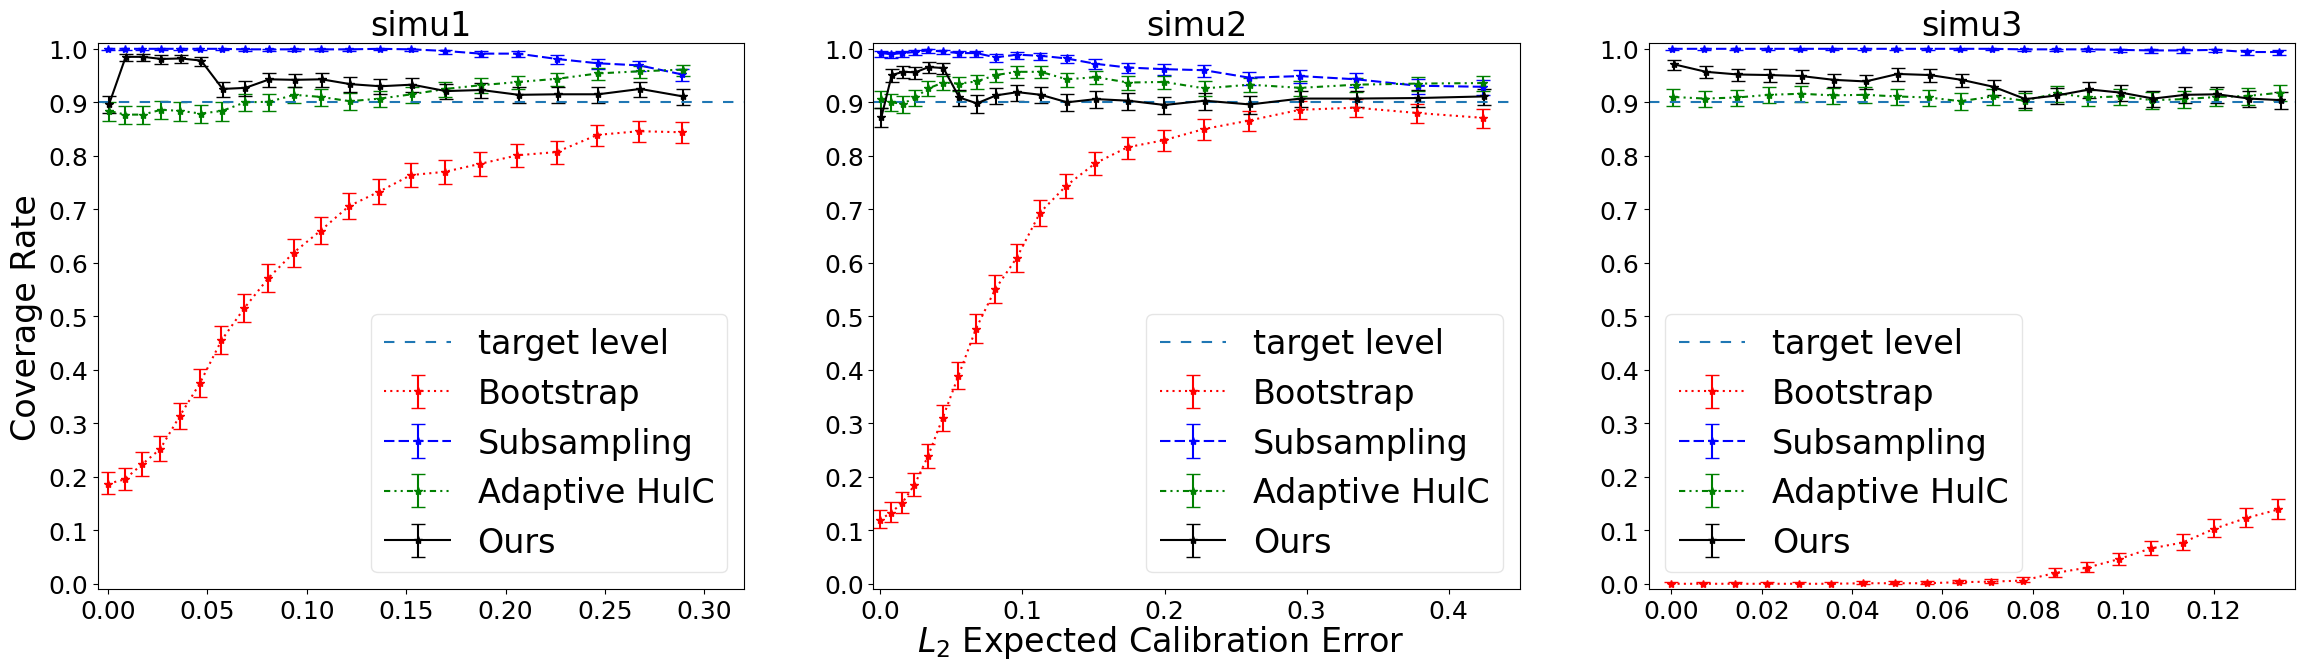

In [11]:
cm = 1/2.54 
figsize=(24*3*cm,18*cm)
fig, axs = plt.subplots(1, 3, figsize=figsize)

for setting_index, setting_name in enumerate(settings):
    for name_index, name in enumerate(plot_coverage_dict):
        num_cover = (np.array(plot_coverage_dict[name][setting_name]) * num_repeat).astype(int)
        temp_lower = num_cover / num_repeat -  scipy.stats.beta.ppf([alpha/2 for _ in range(len(num_cover))], num_cover, num_repeat + 1 - num_cover)
        temp_upper = scipy.stats.beta.ppf([1 - alpha/2 for _ in range(len(num_cover))], num_cover + 1, num_repeat  - num_cover) -  num_cover / num_repeat 
        temp_error = np.stack([temp_lower, temp_upper])
        axs[setting_index].errorbar(plot_ece_dict[name][setting_name] + 0.0002 * name_index, np.array(plot_coverage_dict[name][setting_name]), yerr=temp_error ,fmt="{}*".format(color_dict[name]), ls=line_style_dict[name], capsize=5 ,label=name)

    axs[setting_index].plot(np.arange(-0.005, 0.45, 0.005), np.ones_like(np.arange(-0.005, 0.45, 0.005)) * (1-alpha), linestyle=(0, (5, 5)) ,label="target level")
    axs[setting_index].set_title(setting_name, fontsize=24)
    if setting_index == 0:
        axs[setting_index].set_ylabel("Coverage Rate", fontsize=24)
    axs[setting_index].set_xticks(xticks_dict[setting_name])
    axs[setting_index].set_yticks(np.arange(0.0, 1.01, 0.1))
    axs[setting_index].set_xlim(-0.005, xlim_dict[setting_name])
    axs[setting_index].set_ylim(-0.01, 1.01)
    axs[setting_index].tick_params(axis='both', which='major', labelsize=18)
    if setting_index == 2:
        axs[setting_index].legend(loc="lower left",  fontsize=24, framealpha=0.5)
    else:
        axs[setting_index].legend(loc="lower right",  fontsize=24, framealpha=0.5)

fig.supxlabel(r"$L_2$ Expected Calibration Error", fontsize=24)

Text(0.5, 0.01, '$L_2$ Expected Calibration Error')

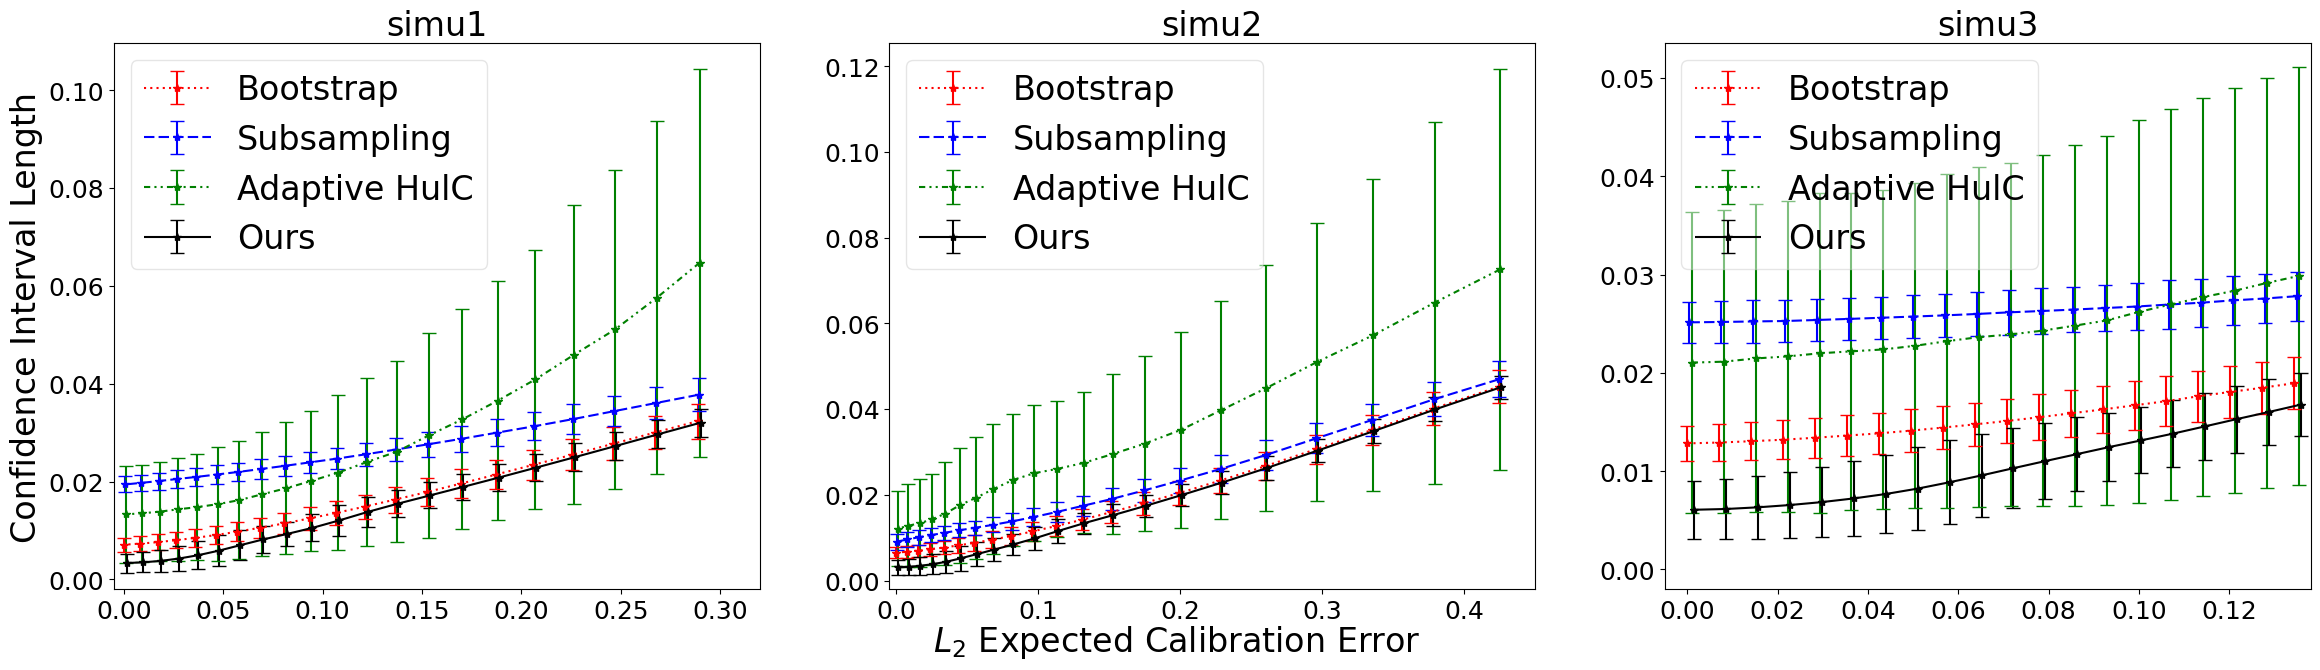

In [12]:
cm = 1/2.54 
figsize=(24*3*cm,18*cm)
fig, axs = plt.subplots(1, 3, figsize=figsize)

for setting_index, setting_name in enumerate(settings):
    for name_index, name in enumerate(plot_coverage_dict):
        temp_middle = plot_interval_dict[name][setting_name]
        temp_lower = z_half_alpha * np.array(plot_interval_std_dict[name][setting_name])
        temp_upper = z_half_alpha * np.array(plot_interval_std_dict[name][setting_name])
        temp_error = np.stack([temp_lower, temp_upper])
        axs[setting_index].errorbar(plot_ece_dict[name][setting_name] + 0.0005 * name_index, temp_middle, yerr=temp_error ,fmt="{}*".format(color_dict[name]), ls=line_style_dict[name], capsize=5 ,label=name)
    axs[setting_index].set_title(setting_name, fontsize=24)
    if setting_index == 0:
        axs[setting_index].set_ylabel("Confidence Interval Length", fontsize=24)
    axs[setting_index].set_xticks(xticks_dict[setting_name])
    axs[setting_index].set_xlim(-0.005, xlim_dict[setting_name])
    axs[setting_index].set_ylim(-0.002)
    axs[setting_index].tick_params(axis='both', which='major', labelsize=18)
    axs[setting_index].legend(loc="upper left",  fontsize=24, framealpha=0.5)
fig.supxlabel(r"$L_2$ Expected Calibration Error", fontsize=24)

Text(0.5, 0.01, '$L_2$ Expected Calibration Error')

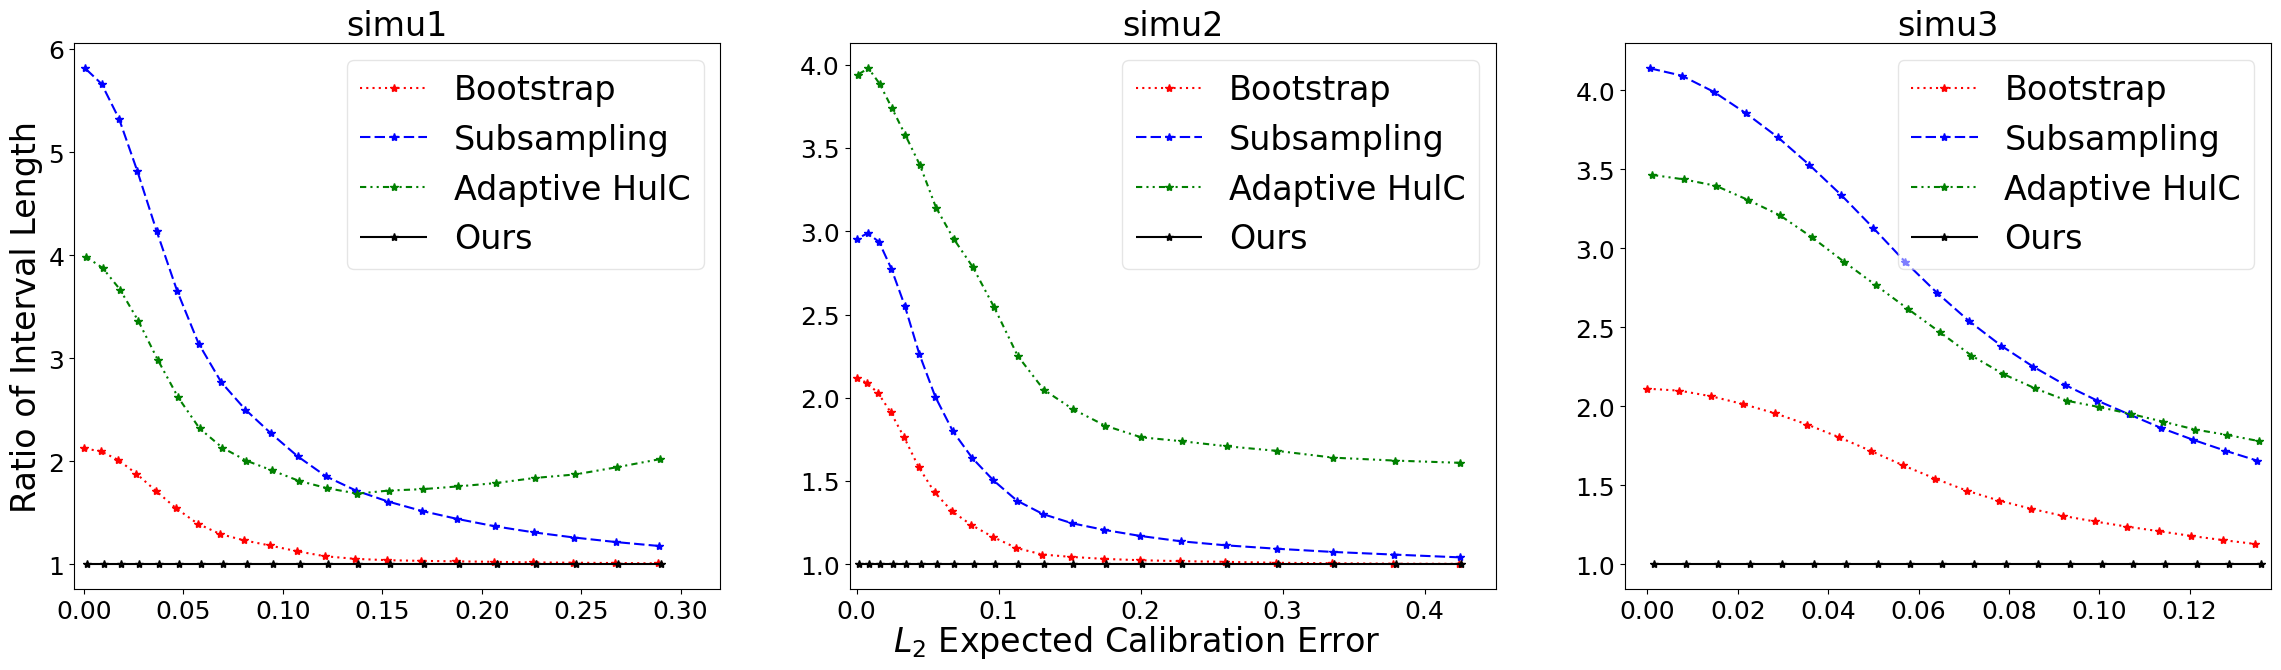

In [13]:
cm = 1/2.54 
figsize=(24*3*cm,18*cm)
fig, axs = plt.subplots(1, 3, figsize=figsize)

for setting_index, setting_name in enumerate(settings):
    for name_index, name in enumerate(plot_coverage_dict):
        axs[setting_index].plot(plot_ece_dict[name][setting_name] + 0.0005 * name_index, np.array(plot_interval_dict[name][setting_name]) / np.array(plot_interval_dict["Ours"][setting_name]) , "{}*".format(color_dict[name]), linestyle=line_style_dict[name],label=name)
    axs[setting_index].set_title(setting_name, fontsize=24)
    if setting_index == 0:
        axs[setting_index].set_ylabel("Ratio of Interval Length", fontsize=24)
    axs[setting_index].set_xticks(xticks_dict[setting_name])
    axs[setting_index].set_xlim(-0.005, xlim_dict[setting_name])
    axs[setting_index].tick_params(axis='both', which='major', labelsize=18)
    axs[setting_index].legend(loc="upper right",  fontsize=24, framealpha=0.5)
fig.supxlabel(r"$L_2$ Expected Calibration Error", fontsize=24)
